In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import calendar
from google.colab import drive

# Konfigurasi Plotting Style
sns.set(style="whitegrid")

In [ ]:
# [1] SETUP ENVIRONMENT & PATH
# ---------------------------------------------------------
drive.mount('/content/drive')

BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Skripsi'
ADMIN_PATH = os.path.join(BASE_PATH, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CRS_TARGET = "EPSG:4326"

# Konfigurasi Filter Confidence (Tingkat Kepercayaan)
# MODIS biasanya menggunakan skala 0-100.
# Nilai > 30 sering dianggap cukup untuk analisis umum (Nominal confidence).
# Nilai > 80 untuk high confidence.
CONFIDENCE_THRESHOLD = 80

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# [2] MEMBUAT FOLDER OUTPUT BARU
# ---------------------------------------------------------
# Kita buat folder khusus agar data bersih tidak bercampur dengan raw data
OUTPUT_FOLDER = os.path.join(BASE_PATH, 'Hotspot Clean Jambi')

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"📂 Folder baru berhasil dibuat: {OUTPUT_FOLDER}")
else:
    print(f"📂 Menggunakan folder yang sudah ada: {OUTPUT_FOLDER}")

📂 Menggunakan folder yang sudah ada: /content/drive/My Drive/Colab Notebooks/Skripsi/Hotspot Clean Jambi


In [ ]:
# [3] DEFINISI PATH DATA RAW (Dari skrip sebelumnya)
# ---------------------------------------------------------
HOTSPOT_PATHS = {
    2010: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587963_2010/fire_archive_M-C61_587963.shp',
    2011: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587964_2011/fire_archive_M-C61_587964.shp',
    2012: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587966_2012/fire_archive_M-C61_587966.shp',
    2013: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587967_2013/fire_archive_M-C61_587967.shp',
    2014: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587968_2014/fire_archive_M-C61_587968.shp',
    2015: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587970_2015/fire_archive_M-C61_587970.shp',
    2016: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587971_2016/fire_archive_M-C61_587971.shp',
    2017: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587972_2017/fire_archive_M-C61_587972.shp',
    2018: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587976_2018/fire_archive_M-C61_587976.shp',
    2019: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587977_2019/fire_archive_M-C61_587977.shp',
    2020: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587978_2020/fire_archive_M-C61_587978.shp'
}

In [ ]:
# [4] EKSEKUSI FILTERING & PENGUMPULAN DATA
# ---------------------------------------------------------
print("\n[INFO] Memuat batas administrasi Jambi...")
jambi_gdf = gpd.read_file(ADMIN_PATH).to_crs(CRS_TARGET)

# List untuk menampung data gabungan (Master Data)
all_hotspots_list = []

print(f"\n[INFO] Memulai proses cleaning & akumulasi data (Threshold >= {CONFIDENCE_THRESHOLD})...")
print("-" * 65)

for year, hs_path in HOTSPOT_PATHS.items():
    if not os.path.exists(hs_path):
        continue

    try:
        # A. LOAD DATA
        gdf = gpd.read_file(hs_path)

        # Samakan CRS
        if gdf.crs != CRS_TARGET:
            gdf = gdf.to_crs(CRS_TARGET)

        # B. FILTER CONFIDENCE
        # Cek nama kolom (sensitif besar/kecil)
        col_conf = next((c for c in gdf.columns if c.lower() == 'confidence'), None)

        if col_conf:
            gdf = gdf[gdf[col_conf] >= CONFIDENCE_THRESHOLD]

        # C. SPATIAL CLIP
        gdf_clipped = gpd.clip(gdf, jambi_gdf)

        # D. SIMPAN & AKUMULASI
        if not gdf_clipped.empty:
            # 1. Simpan Shapefile Bersih per Tahun
            filename = f"Hotspot_Jambi_Clean_{year}.shp"
            gdf_clipped.to_file(os.path.join(OUTPUT_FOLDER, filename))

            # 2. Ambil data tabular untuk analisis statistik
            # Kita hanya butuh tanggal dan nilai confidence, geometri bisa didrop untuk hemat RAM
            col_date = next((c for c in gdf_clipped.columns if 'date' in c.lower()), None)

            if col_date:
                df_temp = pd.DataFrame(gdf_clipped[[col_date, col_conf]].copy())
                df_temp = df_temp.rename(columns={col_date: 'ACQ_DATE', col_conf: 'CONFIDENCE'})
                all_hotspots_list.append(df_temp)

            print(f"✅ {year} | Data tersimpan: {len(gdf_clipped)} titik.")
        else:
            print(f"⚠️ {year} | Tidak ada data setelah clip.")

    except Exception as e:
        print(f"⛔ Error tahun {year}: {e}")


[INFO] Memuat batas administrasi Jambi...

[INFO] Memulai proses cleaning & akumulasi data (Threshold >= 80)...
-----------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2010 | Data tersimpan: 182 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2011 | Data tersimpan: 983 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2012 | Data tersimpan: 1390 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2013 | Data tersimpan: 620 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2014 | Data tersimpan: 815 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2015 | Data tersimpan: 3508 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2016 | Data tersimpan: 32 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


✅ 2017 | Data tersimpan: 36 titik.
✅ 2018 | Data tersimpan: 75 titik.
✅ 2019 | Data tersimpan: 3501 titik.
✅ 2020 | Data tersimpan: 10 titik.


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Field ACQ_DATE created as String field, though DateTime requested.
  ogr_write(


-----------------------------------------------------------------
[INFO] Melakukan rekapitulasi data temporal...
📊 Total Hotspot Terakumulasi: 11152
💾 CSV tersimpan di folder output.


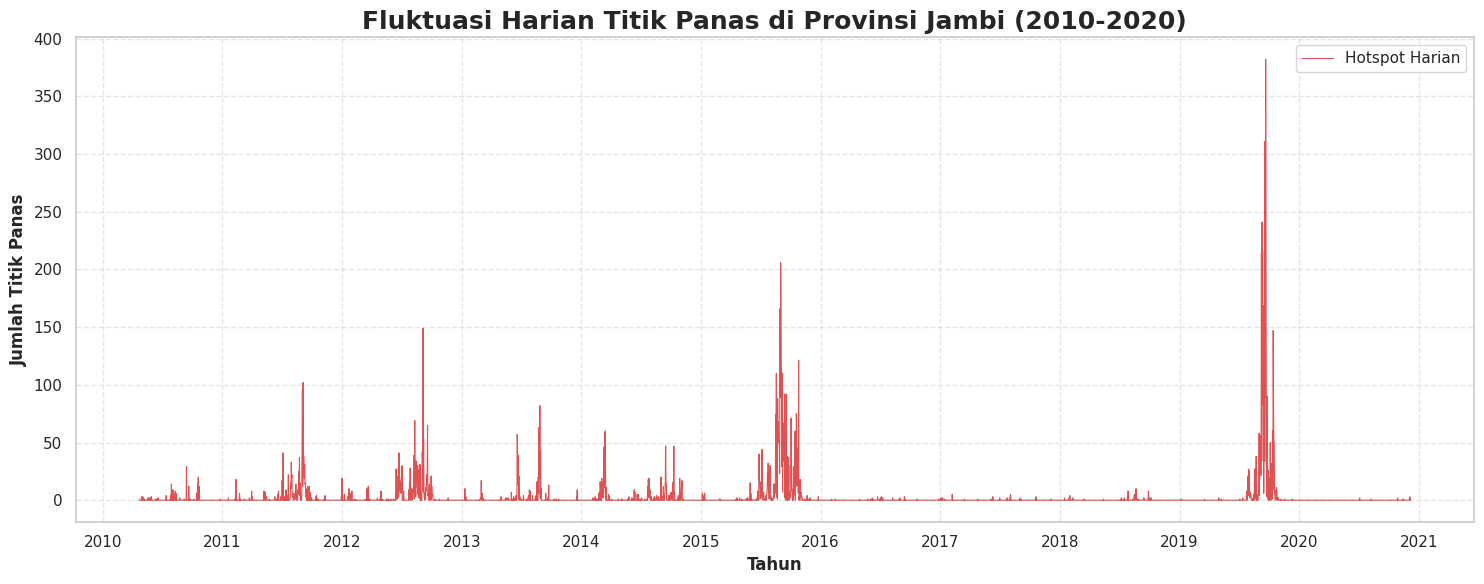

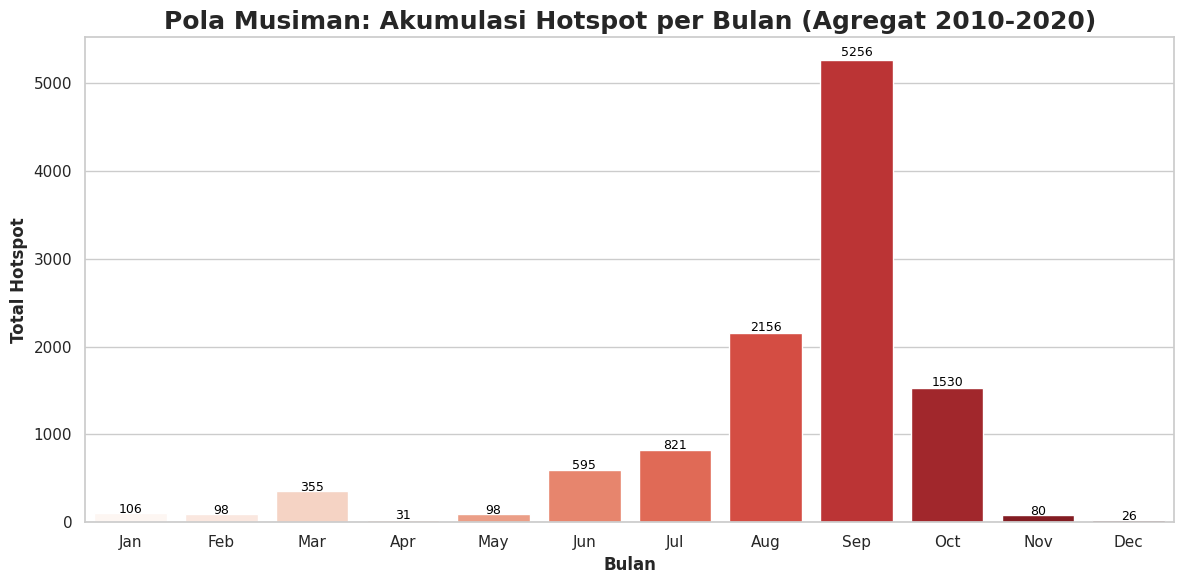

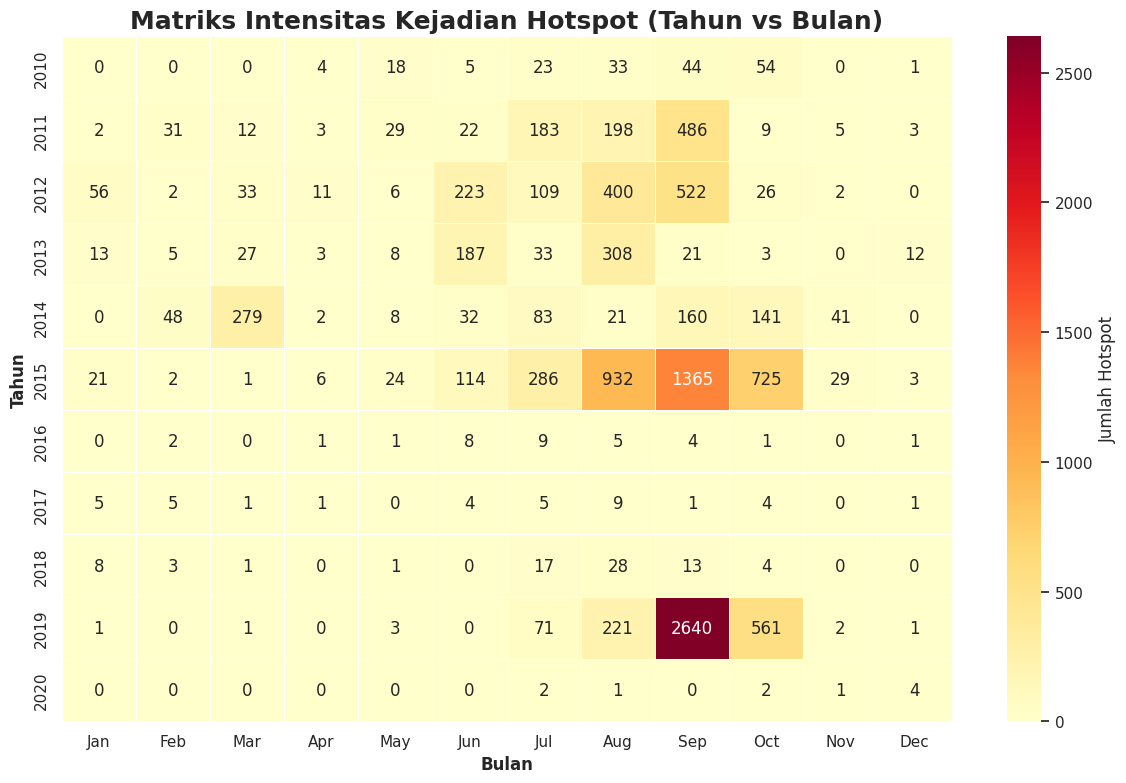

In [ ]:
# [5] REKAPITULASI & ANALISIS TEMPORAL
# ---------------------------------------------------------
print("-" * 65)
print("[INFO] Melakukan rekapitulasi data temporal...")

if all_hotspots_list:
    # Gabung semua data
    master_df = pd.concat(all_hotspots_list, ignore_index=True)
    master_df['ACQ_DATE'] = pd.to_datetime(master_df['ACQ_DATE'])

    # A. REKAP HARIAN & BULANAN
    daily_rec = master_df.set_index('ACQ_DATE').resample('D').size().rename('Hotspot_Count')

    # Update: Menggunakan 'ME' (Month End) untuk menghindari FutureWarning Pandas
    monthly_rec = master_df.set_index('ACQ_DATE').resample('ME').size().rename('Hotspot_Count')

    # Simpan CSV
    path_daily = os.path.join(OUTPUT_FOLDER, 'Rekap_Hotspot_Harian_2010_2020.csv')
    path_monthly = os.path.join(OUTPUT_FOLDER, 'Rekap_Hotspot_Bulanan_2010_2020.csv')
    daily_rec.to_csv(path_daily)
    monthly_rec.to_csv(path_monthly)

    print(f"📊 Total Hotspot Terakumulasi: {master_df.shape[0]}")
    print(f"💾 CSV tersimpan di folder output.")

    # [6] VISUALISASI 1: TIME SERIES (GARIS)
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 6))
    plt.plot(daily_rec.index, daily_rec.values, label='Hotspot Harian', color='#d62728', linewidth=0.8, alpha=0.8)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.title(f'Fluktuasi Harian Titik Panas di Provinsi Jambi (2010-2020)', fontsize=18, fontweight='semibold')
    plt.ylabel('Jumlah Titik Panas', fontweight='semibold')
    plt.xlabel('Tahun', fontweight='semibold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # [7] VISUALISASI 2: POLA MUSIMAN (BAR CHART)
    # ---------------------------------------------------------
    # Menyiapkan data: Ekstrak bulan dari Master DF
    master_df['Month'] = master_df['ACQ_DATE'].dt.month
    monthly_sum = master_df.groupby('Month').size()
    month_labels = [calendar.month_abbr[i] for i in range(1, 13)] # Jan, Feb...

    plt.figure(figsize=(12, 6))
    sns.barplot(x=monthly_sum.index, y=monthly_sum.values, palette="Reds", hue=monthly_sum.index, legend=False)

    plt.title('Pola Musiman: Akumulasi Hotspot per Bulan (Agregat 2010-2020)', fontsize=18, fontweight='semibold')
    plt.ylabel('Total Hotspot', fontweight='bold')
    plt.xlabel('Bulan', fontweight='bold')
    plt.xticks(ticks=range(12), labels=month_labels)

    # Label nilai di atas batang
    for i, v in enumerate(monthly_sum.values):
        plt.text(i, v + (v*0.01), str(v), color='black', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # [8] VISUALISASI 3: HEATMAP (TAHUN vs BULAN)
    # ---------------------------------------------------------
    # Persiapan Data Pivot
    # Kita gunakan resampling bulanan agar sel kosong (0 hotspot) tetap ada
    pivot_source = master_df.set_index('ACQ_DATE').resample('ME').size().to_frame(name='Hotspot_Count')
    pivot_source['Year'] = pivot_source.index.year
    pivot_source['Month'] = pivot_source.index.month

    heatmap_data = pivot_source.pivot_table(index='Year', columns='Month', values='Hotspot_Count', fill_value=0)

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g', linewidths=.5, cbar_kws={'label': 'Jumlah Hotspot'})

    plt.title('Matriks Intensitas Kejadian Hotspot (Tahun vs Bulan)', fontsize=18, fontweight='semibold')
    plt.xlabel('Bulan', fontweight='bold')
    plt.ylabel('Tahun', fontweight='bold')
    plt.xticks(ticks=[i + 0.5 for i in range(12)], labels=month_labels, rotation=0)

    plt.tight_layout()
    plt.show()

else:
    print("❌ Tidak ada data hotspot yang berhasil dikumpulkan untuk dibuat grafik.")